# **<center>Practical Implementation </center>**


## <center>  Programming Session 3 - Graph Representation Learning </center>

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://hm-ai.github.io/ml-enpc/">
    <img src="https://drive.google.com/uc?export=view&id=12t-JTO4co2ZDxqdmNOOZG104izf5bSye" height="50"/>
    Course page</a>
</td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/19GBw_ClpX0z9KzexFU4xzRw3BQ6PTScw?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />Run in Google Colab</a>
  </td>
</table>


# Introduction


The objective of this code is to implement a **Graph Convolutional Network (GCN)** using the **Cora dataset** to classify nodes in a citation network graph. The **Cora dataset** is a benchmark dataset in graph-based machine learning, widely used to evaluate the performance of graph neural networks. It consists of scientific publications (nodes) linked by citation relationships (edges). Each publication belongs to one of several classes, and the task is to predict the class labels for the nodes based on their features and graph structure.

<center><img width="400" src = "https://drive.google.com/uc?export=view&id=122PhORz4VVv88RrAJUzOWbHDqIIGg7kX"></center>

---

### Dataset Overview

The **Cora dataset** is loaded using the `Planetoid` dataset class from the PyTorch Geometric library. Each node in the graph represents a publication, and edges represent citation relationships. The dataset also provides node features (attributes of the publications) and their corresponding class labels. Below are key statistics of the dataset:

- **Number of graphs**: 1
- **Number of nodes**: Total nodes in the citation graph.
- **Number of edges**: Total citation relationships between the publications.
- **Number of features**: Dimensionality of the feature vectors for each node.
- **Number of classes**: Total distinct classes for classification.

Additionally, masks are provided to split the dataset into training, validation, and test subsets.

---

### Graph Convolutional Network (GCN)

The implemented GCN is designed to learn node representations by propagating information through the graph structure. It consists of:
1. **Two GCN layers**:
   - The first layer projects the input node features into a hidden space of 16 dimensions.
   - The second layer produces output scores for classification into the number of classes.
2. **Activation Function**:
   - ReLU activation is applied after the first layer to introduce non-linearity.
3. **Dropout Regularization**:
   - Dropout is applied to reduce overfitting.
4. **Training and Testing**:
   - The model is trained using the Adam optimizer with cross-entropy loss on the training nodes. Testing is performed by calculating accuracy on the test nodes.

---

### Workflow

1. **Dataset Loading**:
   The Cora dataset is loaded, and graph statistics (e.g., number of nodes, edges, isolated nodes, etc.) are printed for verification.

2. **Model Definition**:
   A GCN model is defined with two convolutional layers using `GCNConv` from PyTorch Geometric.

3. **Training**:
   The model is trained for 100 epochs using the training set. The loss is monitored during each epoch.

4. **Testing**:
   The model is evaluated on the test set, and the accuracy of node classification is calculated.

5. **Visualization**:
   The learned node embeddings are visualized, with nodes colored according to their class labels.



# Installing PyTorch Geometric

In [ ]:
# Install required packages.
import os
import torch
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torchinfo import summary
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.5.1+cu121


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [ ]:
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize(
    h, color,
    title="t-SNE Visualization",
    palette="dark",
    size=40,
    alpha=0.8,
    figsize=(8, 8),
    show_axes=False,
    save_path=None,
    random_state=42
):
    """
    Visualizes high-dimensional data using t-SNE and Seaborn with improved customization.

    Parameters:
        h (torch.Tensor): The input data tensor to visualize (of shape [n_samples, n_features]).
        color (array-like): Array of labels or values to color the points (length = n_samples).
        title (str): Title of the plot.
        palette (str or list): Seaborn color palette or list of colors to use.
        size (int): Size of the scatter plot points.
        alpha (float): Transparency of the points.
        figsize (tuple): Size of the figure (width, height).
        show_axes (bool): Whether to show x and y axes ticks and labels.
        save_path (str): File path to save the plot (e.g., "plot.png"). If None, the plot is not saved.
        random_state (int): Random seed for t-SNE reproducibility.
    """
    # Ensure the input tensor is on the CPU and converted to numpy
    if not isinstance(h, torch.Tensor):
        raise ValueError("Input data 'h' must be a torch.Tensor.")
    if len(h.shape) != 2:
        raise ValueError("Input data 'h' must have 2 dimensions: [n_samples, n_features].")

    h_np = h.detach().cpu().numpy()

    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, random_state=random_state)
    z = tsne.fit_transform(h_np)

    # Create a DataFrame for Seaborn compatibility
    df = pd.DataFrame({
        "Dimension 1": z[:, 0],
        "Dimension 2": z[:, 1],
        "Color": color
    })

    # Set up the figure and plot
    plt.figure(figsize=figsize)
    sns.scatterplot(
        x="Dimension 1", y="Dimension 2", hue="Color", palette=palette,
        data=df, s=size, alpha=alpha, edgecolor=None, linewidth=0
    )

    # Customize the plot
    plt.title(title, fontsize=16, fontweight='bold')
    if not show_axes:
        plt.xticks([])  # Hide x-axis ticks
        plt.yticks([])  # Hide y-axis ticks
    else:
        plt.xlabel("Dimension 1", fontsize=12)
        plt.ylabel("Dimension 2", fontsize=12)

    # Add a legend
    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)
    plt.tight_layout()

    # Save the plot if a save path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

# Training a Graph Neural Network (GNN)

The GCN model transforms the input feature vectors associated with each node into output vectors that represent class probabilities for classification. Here’s how the transformation happens step by step:

---

## **1. Input: Node Features and Graph Structure**
- **Node Features ($ \mathbf{X} $)**: A matrix where each row represents the feature vector of a node. Shape: `(num_nodes, num_features)`.

- **Graph Structure ($ \mathbf{A} $)**: Encoded using the adjacency matrix or edge list (`edge_index` in PyTorch Geometric). This defines the connections between nodes.

---

## **2. Layer 1: First Graph Convolution**
- **Goal**: Aggregate information from a node’s neighbors and itself, then transform it into a new feature space.
- **Equation**:
  $$
  \mathbf{H}^{(1)}_v = \mathbf{W}^{(1)} \cdot \left( \sum_{u \in \mathcal{N}(v) \cup \{v\}} \frac{1}{\sqrt{\deg(v) \deg(u)}} \cdot \mathbf{X}_u \right)
  $$
  Where:
  - $ \mathcal{N}(v) $: Set of neighbors of node $ v $.
  - $ \deg(v) $: Degree of node $ v $ (number of neighbors).
  - $ \mathbf{W}^{(1)} $: Trainable weight matrix for the first layer.

- **Transformation**:
  - Input: $ \mathbf{X} $ (node features).
  - Output: $ \mathbf{H}^{(1)} $, a new feature matrix of shape `(num_nodes, hidden_channels)`.

---

## **3. Non-Linearity: ReLU Activation**
- After the first graph convolution, a ReLU activation function is applied to introduce non-linearity:
  $$
  \mathbf{H}^{(1)} = \text{ReLU}(\mathbf{H}^{(1)})
  $$

---

## **4. Regularization: Dropout**
- Dropout is applied to prevent overfitting by randomly setting some elements of $ \mathbf{H}^{(1)} $ to zero during training:
  $$
  \mathbf{H}^{(1)}_{\text{dropout}} = \text{Dropout}\left(\mathbf{H}^{(1)}, p=0.5\right)
  $$
  - $ p=0.5 $: 50% probability of dropping a feature.

---

## **5. Layer 2: Second Graph Convolution**
- **Goal**: Use the transformed features from Layer 1 to predict class probabilities for each node.
- **Equation**:
  $$
  \mathbf{Z}_v = \mathbf{W}^{(2)} \cdot \left( \sum_{u \in \mathcal{N}(v) \cup \{v\}} \frac{1}{\sqrt{\deg(v) \deg(u)}} \cdot \mathbf{H}^{(1)}_{\text{dropout}, u} \right)
  $$
  Where:
  - $ \mathbf{W}^{(2)} $: Trainable weight matrix for the second layer.

- **Transformation**:
  - Input: $ \mathbf{H}^{(1)}_{\text{dropout}} $.
  - Output: $ \mathbf{Z} $, a matrix of shape `(num_nodes, num_classes)`.

---

## **6. Output: Node Classification**
- Each row in $ \mathbf{Z} $ corresponds to the predicted class scores for a node.
- These scores can be passed through a softmax function to obtain class probabilities:
  $$
  \text{Probabilities} = \text{Softmax}(\mathbf{Z})
  $$

---

## **Full Transformation Pipeline**

$$
\mathbf{Z} = \text{Softmax}\left(\text{GCNConv}_2\left(\text{Dropout}\left(\text{ReLU}\left(\text{GCNConv}_1\left(\mathbf{X}, \mathbf{A}\right)\right), p=0.5\right), \mathbf{A}\right)\right)
$$

1. **Input**: $ \mathbf{X} $, $ \mathbf{A} $.
2. **Layer 1**: Graph convolution ($ \text{GCNConv}_1 $) → ReLU → Dropout.
3. **Layer 2**: Graph convolution ($ \text{GCNConv}_2 $) → Output $ \mathbf{Z} $.
4. **Softmax** : Convert $ \mathbf{Z} $ to probabilities.

---

## **Model Summary**

The model architecture can be summarized as:
```plaintext
Input Features (X) → GCNConv1 → ReLU → Dropout → GCNConv2 → Softmax → Output Scores (Z)


In [ ]:
# Print dataset details and shapes of the data
print("Dataset Details:")
print(f"Number of nodes: {data.num_nodes}")  # Shape: [num_nodes]
print(f"Number of edges: {data.num_edges // 2}")  # Undirected edges
print(f"Number of features per node: {data.num_node_features}")  # Shape: [num_features]
print(f"Number of classes: {dataset.num_classes}")  # Shape: [num_classes]
print(f"Training nodes: {int(data.train_mask.sum())}")
print(f"Validation nodes: {int(data.val_mask.sum())}")
print(f"Testing nodes: {int(data.test_mask.sum())}\n")

Dataset Details:
Number of nodes: 2708
Number of edges: 5278
Number of features per node: 1433
Number of classes: 7
Training nodes: 140
Validation nodes: 500
Testing nodes: 1000



---
<font color=green>Q1:</font>
<br><font color='green'>
Implement a Graph Convolutional Network (GCN) in PyTorch to classify the nodes in the Cora dataset.
</font>

----



Your implementation should include:
- Two graph convolutional layers using `GCNConv`.
- ReLU activation after the first layer.
- Dropout for regularization.
- A forward method to process node features and edge indices.
Additionally, initialize the model with a hidden channel size of 16, and print its architecture and a summary of the model.


### Constraints:
- Use `GCNConv` from the PyTorch Geometric library.
- The first GCN layer should map input features to the hidden dimension.
- The second GCN layer should map the hidden dimension to the number of classes.

### Input:
- `data.x`: Node feature matrix of shape `[num_nodes, num_features]`.
- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]`.

### Output:
- The model architecture and a summary showing output size and number of parameters.


Model Architecture:
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
GCN                                      [2708, 7]                 --
├─GCNConv: 1-1                           [2708, 16]                16
│    └─Linear: 2-1                       [2708, 16]                22,928
│    └─SumAggregation: 2-2               [2708, 16]                --
├─GCNConv: 1-2                           [2708, 7]                 7
│    └─Linear: 2-3                       [2708, 7]                 112
│    └─SumAggregation: 2-4               [2708, 7]                 --
Total params: 23,063
Trainable params: 23,063
Non-trainable params: 0
Total mult-adds (M): 62.39
Input size (MB): 15.69
Forward/backward pass size (MB): 0.50
Params size (MB): 0.09
Estimated Total Size (MB): 16.28


---
<font color=green>Q2:</font>
<br><font color='green'>
Implement the training process for a Graph Convolutional Network (GCN) in PyTorch. Your solution should include:
- An Adam optimizer with a learning rate of 0.01 and a weight decay of 5e-4.
- A CrossEntropyLoss function for node classification.
- A training function that performs one epoch, computes the loss, and updates the model parameters.

Make sure to:
- Use the model's forward method to compute predictions.
- Use a training mask to calculate the loss only for the training nodes.
- Return the loss value for the epoch.
</font>
---

### Input:
- `data.x`: Node feature matrix of shape `[num_nodes, num_features]`.
- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]`.
- `data.train_mask`: Boolean mask identifying training nodes.
- `data.y`: Ground-truth labels for all nodes.

### Output:
- The training loss for the epoch after updating the model parameters.


Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


---
<font color=green>Q3:</font>
<br><font color='green'>
Implement a testing function for the Graph Convolutional Network (GCN) in PyTorch. Your solution should:
- Evaluate the model on a test dataset.
- Use the model's forward method to compute predictions.
- Calculate the accuracy for the test nodes using a test mask.
- Print the test accuracy after evaluation.
Ensure the function switches the model to evaluation mode during testing.
</font>

---

### Input:
- `data.x`: Node feature matrix of shape `[num_nodes, num_features]`.
- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]`.
- `data.test_mask`: Boolean mask identifying test nodes.
- `data.y`: Ground-truth labels for all nodes.

### Output:
- The test accuracy as a float, rounded to four decimal places.


Test Accuracy: 0.8150


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

---
<font color=green>Q4:</font>
<br><font color='green'>
Write a script to visualize the embeddings generated by a trained Graph Convolutional Network (GCN). Your solution should:
- Switch the model to evaluation mode.
- Perform a forward pass on the input data to compute embeddings.
- Use a visualization function to plot the embeddings, coloring them by their ground-truth labels.

Ensure that the visualization clearly shows the structure of the embeddings.
</font>

---

### Input:
- `data.x`: Node feature matrix of shape `[num_nodes, num_features]`.
- `data.edge_index`: Graph connectivity in COO format with shape `[2, num_edges]`.
- `data.y`: Ground-truth labels for all nodes.

### Output:
- A 2D visualization of the node embeddings, where nodes are colored by their ground-truth labels.




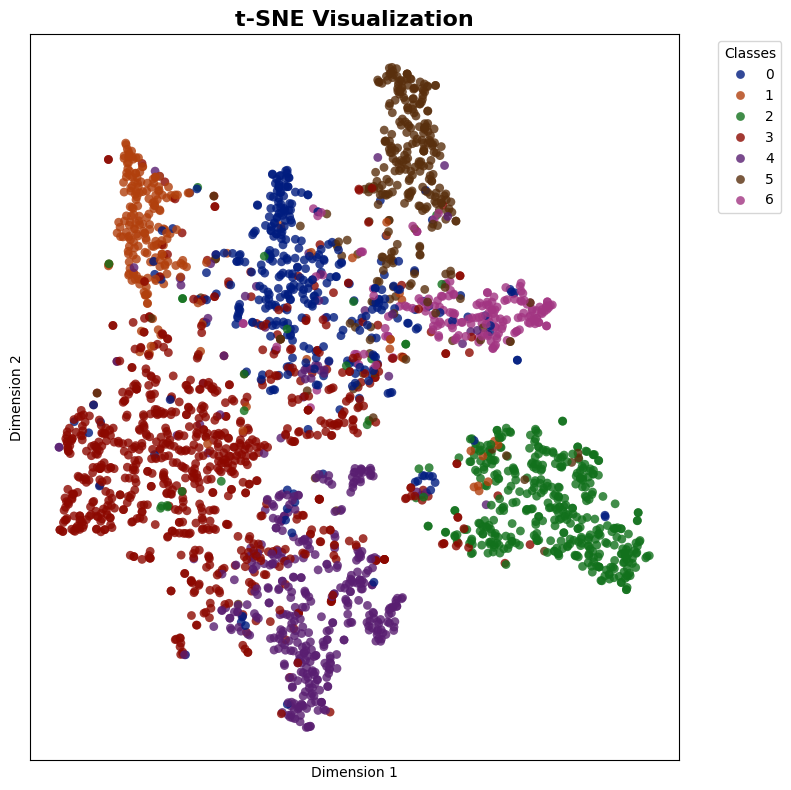